# Interrupted time series analysis on the impact of introducing hepA vaccine into the mandatory vaccination schedule.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [1]:
import warnings; warnings.simplefilter('ignore')

## 2. Pre-analysis

### 2.1 Visualizing incidence of vaccine-preventable diseases over time

In [4]:
mask = ['hepatitis_A']
vaccine_pd = (pd.read_csv('../datasets/vaccine-preventable-diseases.csv')
                 .set_index('year', drop=True)
                 .loc[:, mask])

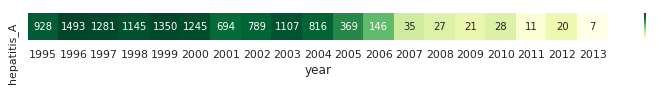

In [5]:
fig, ax = plt.subplots(1,1,figsize=(13,0.5))
sns.heatmap(np.log(vaccine_pd.T+0.1), robust=True, annot=vaccine_pd.T, fmt="d",
            cmap='YlGn', ax = ax, cbar_kws={'ticks':[]}); plt.show()

**Figure one:** Heatmap showing the number of hepatitis A. All cases reported came from public hospitals located in Buenos Aires City. Darker colors represent bigger number of reported cases.

### 2.2 Visualizing yearly hepA vaccination numbers

In [8]:
mask = ['antihepatitis_A_peds', 'antihepatitis_A_adul', 'antihepatitis_A_brote']
vaccine_records = (pd.read_csv('../datasets/vaccination-records.csv')
                       .set_index('year', drop=True)
                       .loc[:, mask]
                       .assign(hepA_total = lambda x: x.sum(axis=1)))

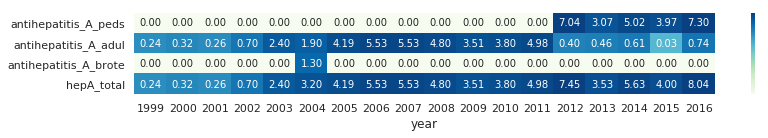

In [12]:
fig, ax = plt.subplots(1,1,figsize=(13,1.5))
sns.heatmap(np.log(vaccine_records.T+0.1), robust=True, annot=np.divide(vaccine_records.T,10_000),
            fmt=".2f", cmap='GnBu', ax = ax, cbar_kws={'ticks':[]}); plt.show()

**Figure two:** Heatmap showing yearly vaccination numbers, a 1 being equals to 10.000 vaccines administered that year.

### 2.3 Setting the dataframe for analysis

In [15]:
data = (pd.DataFrame({'year': range(1995,2017)})
            .merge(vaccine_records['hepA_total'].reset_index(), on='year', how='left')
            .merge(vaccine_pd['hepatitis_A'].reset_index(), on='year', how='left')
            .assign(vaccines_sum = lambda x: x['hepA_total'].cumsum())
            .rename(columns={'hepA_total':'vaccines', 'hepatitis_A':'cases'})
            .set_index('year')
       )

## 3. Analysis

**Figure three:** On the left, a line plot shows the yearly number of both the cases of hepA and the number of vaccines administered to the public, the latter is in a per hundreds scale. On the right, a scatter plot shows the relationship between the number of vaccine administered and the number of hepA cases on that year.

### 3.1 Reggression analysis

In [16]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [20]:
glm_model = smf.glm('cases ~ I(vaccines_sum/10000)', 
                    family=sm.families.Poisson(), 
                    data = data).fit(cov_type='HC3')

In [21]:
print(str(glm_model.summary())[790:])

                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   7.1210      0.114     62.413      0.000       6.897       7.345
I(vaccines_sum / 10000)    -0.1130      0.009    -11.970      0.000      -0.131      -0.094


#### 3.1.1 Model interpretation

For every 10.000 people vaccinated, hepA cases decreases by 11% (IRR: 0.89, CI 0.87 - 0.90).

In [26]:
data = data.assign(glm_pred = lambda x: glm_model.predict(x.loc[range(1999,2014),'vaccines_sum']))

### 3.2 Interrupted time series

In [51]:
itt = (data.loc[range(1995,2014)]
           .assign(time = 1)
           .assign(time = lambda x: x['time'].cumsum(),
                   intervention = lambda x: x['time'].apply(lambda x: 1 if x > 11 else 0))
           .loc[:,['cases','time', 'intervention', 'vaccines_sum']])

In [52]:
itt_model = smf.glm('cases ~ time + intervention + time:intervention', 
                family=sm.families.Poisson(), 
                data = itt).fit(cov_type='HC3')

In [53]:
print(str(itt_model.summary())[790:])

                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.3043      0.167     43.611      0.000       6.976       7.633
time                 -0.0665      0.029     -2.327      0.020      -0.123      -0.010
intervention          2.2769      1.433      1.589      0.112      -0.532       5.085
time:intervention    -0.3454      0.100     -3.450      0.001      -0.542      -0.149


#### 3.2.1 Model interpretation

Following the introduction of hepatitis A vaccine into the mandatory vaccination schedule in 2006, no immediate effect could be observed in number of new hepatitis A cases (IRR: 9.74, CI95: 0.58 - 161.62). However, after its introduction, the rate in which new cases decrease yearly became 1.3 times faster than the pre-intervention period (Post-intervention IRR: 0.70, CI95: 0.58 - 0.86 vs Pre-intervention IRR: 0.93, CI95: 0.88 - 0.98).

In [56]:
itt = (itt.assign(
    wo_intervention = lambda x: itt_model.predict(pd.DataFrame({'time':x['time'],'intervention':0})),
    w_intervention = lambda x: itt_model.predict(pd.DataFrame({'time':x['time'],'intervention':1}))))

## 4. Figures

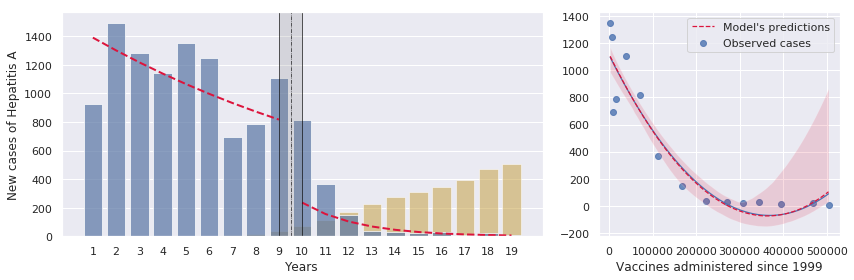

In [63]:
fig, (axa, axb) = plt.subplots(1,2,figsize=(12,4), gridspec_kw = {'width_ratios':[2, 1]})

sns.regplot(data.loc[range(1999,2014), 'vaccines_sum'], data.loc[range(1999,2014), 'cases'],
           order=2, truncate=True, ci=False, label='Observed cases', ax=axb) 
sns.regplot(data.loc[range(1999,2014), 'vaccines_sum'], data.loc[range(1999,2014), 'glm_pred'],
           order=2, truncate=True, scatter=False, color='crimson', label="Model's predictions", ax=axb)

axb.lines[1].set_linestyle("--"); axb.lines[0].set_linewidth(1.25); axb.lines[1].set_linewidth(1.25)
axb.set_ylabel(''); axb.set_xlabel('Vaccines administered since 1999')
axb.legend()


sns.barplot(itt['time'], np.divide(itt['vaccines_sum'],1000), color = 'goldenrod', alpha = 0.5, ax = axa)
sns.barplot('time', 'cases', color = 'b', alpha = 0.7, data = itt, ax = axa)
sns.lineplot(range(0,9), itt.loc[range(1995,2004),'wo_intervention'], color = 'crimson', ax = axa)
sns.lineplot(range(9,19), itt.loc[range(2004,2014),'w_intervention'], color = 'crimson', ax = axa)

axa.lines[38].set_linestyle("--"); axa.lines[39].set_linestyle("--")
axa.lines[38].set_linewidth(2); axa.lines[39].set_linewidth(2)

axa.set_ylabel('New cases of Hepatitis A'); axa.set_xlabel('Years'); 

axa.axvline(8.5, c='black', lw=0.6, ls='-.')
axa.axvline(8, c='black', lw=0.6);axa.axvline(9, c='black', lw=0.6)
axa.axvspan(8, 9, alpha=0.2, color='grey')

plt.tight_layout()
plt.show()